In [2]:
# Install CHAID library (used for rule induction)
!pip install --quiet CHAID

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression

import pickle


In [3]:
from google.colab import files
uploaded = files.upload()    # Upload WA_Fn-UseC_-Telco-Customer-Churn.csv

df = pd.read_csv(list(uploaded.keys())[0])
df.head()


Saving WA_Fn-UseC_-Telco-Customer-Churn.csv to WA_Fn-UseC_-Telco-Customer-Churn (1).csv


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
df.replace(" ", np.nan, inplace=True)
df.dropna(inplace=True)

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'])
df.drop('customerID', axis=1, inplace=True)

encoder = LabelEncoder()
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = encoder.fit_transform(df[col])

df.head()


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,29.85,0
1,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1889.50,0
2,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,108.15,1
3,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,42.30,1840.75,0
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65,1


In [5]:
X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)


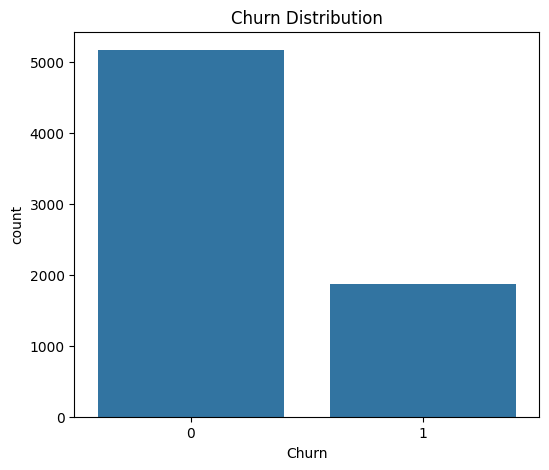

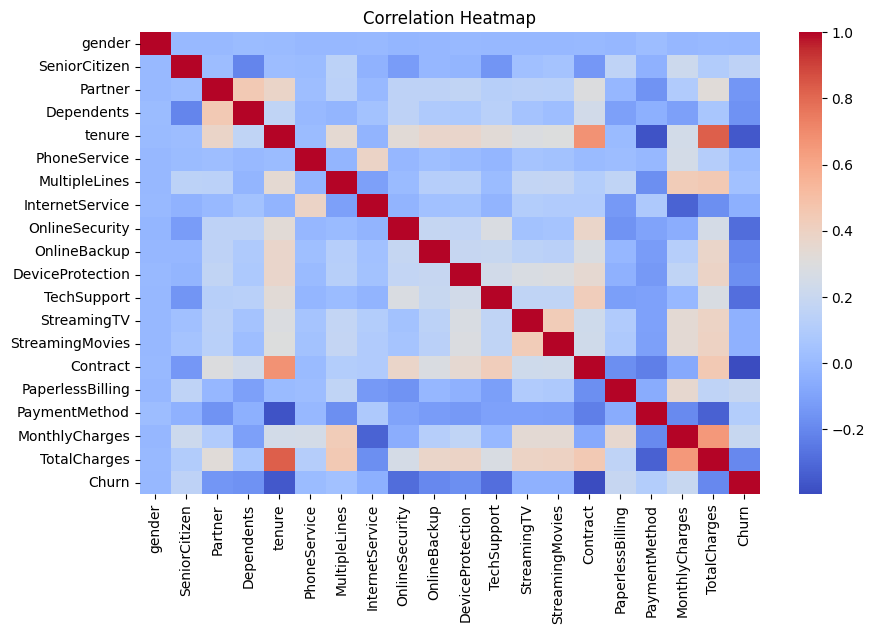

In [6]:
plt.figure(figsize=(6,5))
sns.countplot(x=df['Churn'])
plt.title("Churn Distribution")
plt.show()

plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


CHAID Model Accuracy: 0.7815699658703071
Confusion Matrix:
 [[1165  135]
 [ 249  209]]


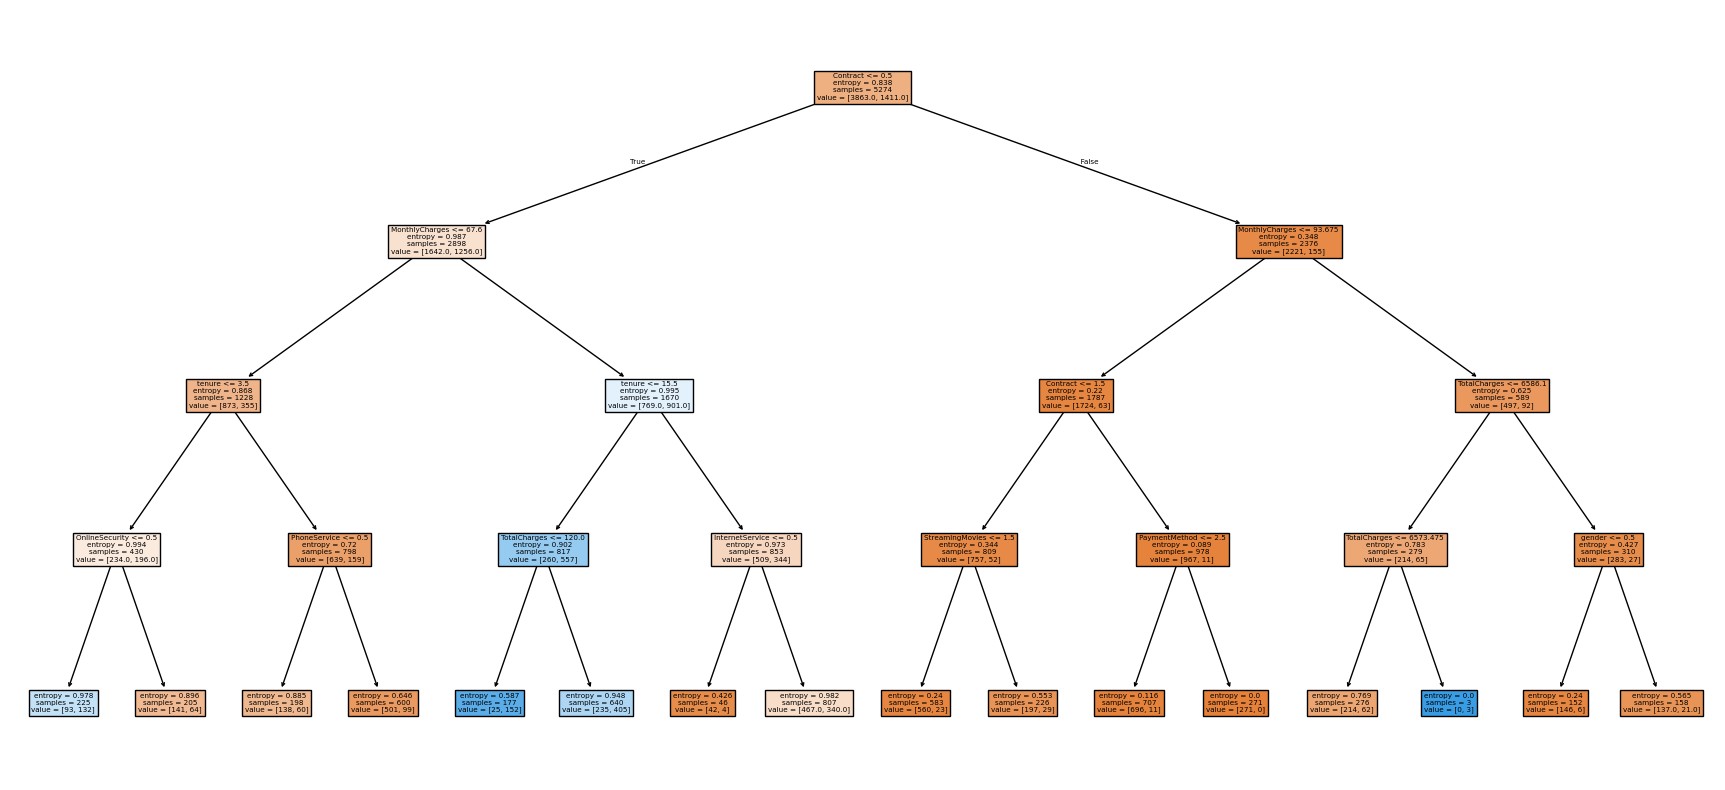

In [7]:
chaid_model = DecisionTreeClassifier(criterion="entropy", max_depth=4)
chaid_model.fit(X_train, y_train)

y_pred_tree = chaid_model.predict(X_test)

print("CHAID Model Accuracy:", accuracy_score(y_test, y_pred_tree))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_tree))

plt.figure(figsize=(22,10))
plot_tree(chaid_model, feature_names=X.columns, filled=True)
plt.show()


In [8]:
log_model = LogisticRegression(max_iter=200)
log_model.fit(X_train, y_train)

y_pred_log = log_model.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))


Logistic Regression Accuracy: 0.7906712172923777
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1300
           1       0.62      0.52      0.56       458

    accuracy                           0.79      1758
   macro avg       0.73      0.70      0.71      1758
weighted avg       0.78      0.79      0.78      1758



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


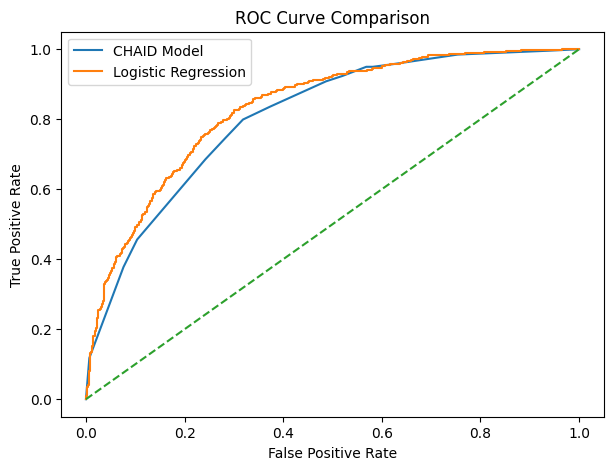

CHAID ROC-AUC: 0.8075713805844811
Logistic ROC-AUC: 0.8319281155525697


In [9]:
y_prob_tree = chaid_model.predict_proba(X_test)[:,1]
y_prob_log = log_model.predict_proba(X_test)[:,1]

fpr1, tpr1, _ = roc_curve(y_test, y_prob_tree)
fpr2, tpr2, _ = roc_curve(y_test, y_prob_log)

plt.figure(figsize=(7,5))
plt.plot(fpr1, tpr1, label="CHAID Model")
plt.plot(fpr2, tpr2, label="Logistic Regression")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()

print("CHAID ROC-AUC:", roc_auc_score(y_test, y_prob_tree))
print("Logistic ROC-AUC:", roc_auc_score(y_test, y_prob_log))


In [10]:
best_model = log_model   # choose best based on ROC-AUC
pickle.dump(best_model, open("churn_model.pkl", "wb"))
print("✅ Model saved as churn_model.pkl")


✅ Model saved as churn_model.pkl
